In [18]:
import pandas as pd
import numpy as np
from scipy import stats
import scipy
from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


import pandahouse as ph

## ***Задание 1. A/B–тестирование***
#### 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

## Решение

#### 0. Загрузка данных

In [23]:
groups = pd.read_csv(
    'groups.csv',
    sep = ';')
# Файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе 
# (А – контроль (базовая механика) , B – целевая группа(новая механика))

In [24]:
groups_add = pd.read_csv(
    'group_add.csv')
# Дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

In [25]:
active_studs = pd.read_csv(
    'active_studs.csv',
    sep=';')
# Файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента

In [26]:
checks = pd.read_csv(
    'checks.csv',
    sep=';')
# Файл с информацией об оплатах пользователей в дни проведения эксперимента

#### 1. Предобработка имеющихся данных
Иследуем направленные файлы:
- Какой объем данных? Какое наполнение?
- Какие типы данных используются? 
- Есть ли пропущенные значения? 
- Есть ли дубли? 

In [27]:
groups.head()
# Проверим состав колонок df и удостоверимся, что данные выгрузились нормально

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [28]:
groups.count(), groups_add.count(), active_studs.count(), checks.count()
# Подсчет количества строк в dfs

(id     74484
 grp    74484
 dtype: int64,
 id     92
 grp    92
 dtype: int64,
 student_id    8341
 dtype: int64,
 student_id    541
 rev           541
 dtype: int64)

In [29]:
groups.nunique(), groups_add.nunique(), active_studs.nunique(), checks.nunique()
# Подсчет количества уникальных строк в dfs
# => дубли отсутствуют

(id     74484
 grp        2
 dtype: int64,
 id     92
 grp     2
 dtype: int64,
 student_id    8341
 dtype: int64,
 student_id    541
 rev            39
 dtype: int64)

In [30]:
groups.isna().sum(), groups_add.isna().sum(), active_studs.isna().sum(), checks.isna().sum()
# Проверка пустых значений в dfs

(id     0
 grp    0
 dtype: int64,
 id     0
 grp    0
 dtype: int64,
 student_id    0
 dtype: int64,
 student_id    0
 rev           0
 dtype: int64)

In [31]:
groups.dtypes, groups_add.dtypes, active_studs.dtypes, checks.dtypes
# Проверка типов данных в dfs

(id      int64
 grp    object
 dtype: object,
 id      int64
 grp    object
 dtype: object,
 student_id    int64
 dtype: object,
 student_id      int64
 rev           float64
 dtype: object)

В результате предобработки данных выяснено: 
- количество строк в каждом из df
- наполнение df (что находится в столбцах)
- в датафреймах отсутствуют повторяющиеся и пропущенные строки

In [32]:
# Количество пользователей в каждой из групп (1-й df)
groups.groupby('grp', as_index = False) \
    .agg({'id': 'count'})

,grp,id
0,A,14671
1,B,59813


In [33]:
# Количество пользователей в каждой из групп (дополнительный df)
groups_add.groupby('grp', as_index = False) \
    .agg({'id': 'count'})

,grp,id
0,A,22
1,B,70


В обоих df заметна диспропорация групп: клиентов с новым способом оплаты сильно больше, чем с базовым

In [34]:
# Валовая сумма дохода в дни проведения эксперимента
checks.rev.sum()

573326.0035999999

In [35]:
# Добавление дополнительных клиентов в df
both_groups = pd.concat([groups, groups_add])

In [36]:
# Проверка отсутствия повторяющихся ID между двумя df
both_groups.id.nunique() == groups.id.count() + groups_add.id.count()

True

In [37]:
# Чтобы избежать сложности с объединением df, переименум колонку с ID в единый вид
both_groups = both_groups.rename(columns=({'id': 'student_id'}))

In [38]:
checks.merge(active_studs, on='student_id', how='inner')

,student_id,rev
0,1627,990.0000
1,100300,990.0000
2,108270,290.0000
3,264473,1900.0001
4,274352,690.0000
...,...,...
387,5645737,1900.0000
388,5651566,1900.0000
389,5662322,1900.0000
390,5681918,1900.0000


In [39]:
checks

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


Обнаружена следующая ситуация: 

По условию, в таблице active_studs находятся пользователи, зашедшие в дни эксперимента на сайт. В таблице checks - пользователи, совершившие покупки в дни эксперимента. 

На двух строках выше видно сравнение двух df - объединенение *посетителей* (active_studs) с checks имеет меньше строк (т.е. число купивших пользователей) , чем checks сам по себе (392vs541). 

Получается, что из 541 совершивших покупку пользователей, зашли на платформу только 392. Возникает вопрос, к кому относятся оставшиеся пользователи. Точно ответить на него не позволяет имеющееся условие, поэтому можно сделать предположения: 
- Произошла техническая ошибка и не все оплатившие записаны в посетителей
- Произошла техническая ошибка и в checks попали клиенты, совершившие покупки оффлайн

Для текущих целей проекта, будем считать, что справедлив п.1. Добавим всех оплативших пользователей в df

In [40]:
# Присоединение к посетителям платформы данных о группе
full_info_test = both_groups.merge(active_studs, on='student_id', how='inner') \
    .merge(checks, on='student_id', how='outer') 

В df нет данных о типах продуктов, однако можно проанализировать суммы покупок: 

In [41]:
# Группировка количества покупок по сумме покупки
full_info_test.groupby('rev', as_index = False) \
    .agg({'student_id':'count'}) \
    .sort_values('student_id', ascending = False)

,rev,student_id
24,1900.0000,97
1,290.0000,94
8,690.0000,78
0,199.0000,46
13,990.0000,41
25,1900.0001,36
10,840.0000,27
16,1140.0000,25
4,580.0000,15
5,590.0000,11


Выделяются первые три суммы: 1900; 290; 690. Количество покупок на такую сумму отрывается от прочих сумм.

Можно предположить, что имеет место быть скидка или какая-то маркетинговая кампания, что может сказаться на достоверности выводов эксперимента. 

Посмотрим то же самое в разрезе групп:

In [42]:
full_info_test.query('grp == "A"') \
    .groupby('rev', as_index=False) \
    .agg({'student_id': 'count'}) \
    .sort_values('student_id', ascending=False)

,rev,student_id
1,290.0,25
4,580.0,6
0,199.0,5
9,990.0,5
5,590.0,5
6,690.0,4
14,1530.0,3
22,3660.0,3
7,840.0,3
3,489.0,2


In [43]:
full_info_test.query('grp == "B"') \
    .groupby('rev', as_index=False) \
    .agg({'student_id': 'count'}) \
    .sort_values('student_id', ascending=False)

,rev,student_id
20,1900.0000,93
1,290.0000,45
21,1900.0001,35
0,199.0000,27
9,840.0000,21
12,990.0000,17
7,690.0000,13
14,1140.0000,9
2,398.0000,6
5,590.0000,6


Явно видно, что в группе с базовым методом оплаты нет варианта суммы покупки == 1900, в то время как в группе с новым методом оплаты - есть и много. 
С имеющимися условиями сложно сказать причину такой разбивки. Возможно, существует какая-то партнерская программа с МПС (например, МИР), которая предполагает кэшбэк / бонусы / иное. 

**Видится два дальнейших пути:**
1. Необходимо получить у коллег детали по поводу ситуации с одинаковыми чеками. Возможно, имеет место быть проблема взаимодействия отделов и у нашего теоритического подразделения не было информации о запуске некой акции подразделением маркетинга. В таком случае, чистота эксперимента под сомнением, его необходимо тщательнее подготовить во взаимодействии с остальными подразделениями и провести заново.

2. Продолжить эксперимент, понимая его ограниченную полезность из-за сложности выявления в данный момент, что именно влияет на показатели: новая оплата или акция. 

Для академических целей и отработки навыков, выберем п.2, однако в реальной обстановке разумнее выбрать п.1 и детальнее разобраться в ситуации.

In [44]:
# Вывод количества пользователей в каждой из групп 
full_info_test.groupby('grp', as_index=False) \
    .agg({'student_id': 'count'})

,grp,student_id
0,A,1538
1,B,6803


Видна диспропорция количества пользователей в группах

In [45]:
# Создание df с фильтром на группу А для простоты дальнейшего использования
A_group_full_info_test = full_info_test.query('grp == "A"').fillna(0)

In [46]:
# Создание df с фильтром на группу B для простоты дальнейшего использования
B_group_full_info_test = full_info_test.query('grp == "B"').fillna(0)

#### 2. Сравнение метрик групп. Формулировка и проверка гипотез

Определим метрики, которые будут проанализированы для вывода о результатах тестирования:
- Средняя сумма покупки среди плативших пользователей
- Конверсия из посетителей платформы в покупку

Необходимо:
- посчитать показатели для обеих групп
- оценить распределение 
- выбрать критерий для подтверждения гипотез значимости отличия
- сделать вывод

In [47]:
# Конверсия зашедших на платформу в покупку для группы А
CR_A = A_group_full_info_test.query('rev > 0').student_id.count() / A_group_full_info_test.student_id.count()*100
CR_A

5.071521456436931

In [48]:
# Конверсия зашедших на платформу в покупку для группы B
CR_B = B_group_full_info_test.query('rev > 0').student_id.count() / B_group_full_info_test.student_id.count()*100
CR_B

4.615610759958842

Согласно расчетам выше, конверсия посетителей, имевших новый метод оплаты, снизилась относительно старой версии.

Можно предположить, что новый метод оплаты не оказал положительного влияния на клиентов. Более того, возможно он стал менее удобным (меньше клиентов доходит до покупки). 

Возможно, есть связь с обнаруженной раньше ошибкой отнесения клиентов с оплатой к посетителям. 

In [49]:
# Средний чек покупки для группы A (исключены ID без покупок)
mean_A = A_group_full_info_test.query('rev > 0').rev.mean()
mean_A

933.5897435897435

In [50]:
# Средний чек покупки для группы B (исключены ID без покупок)
mean_B = B_group_full_info_test.query('rev > 0').rev.mean()
mean_B

1257.878992038217

C:\Users\Evgeniy\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rev', ylabel='Density'>

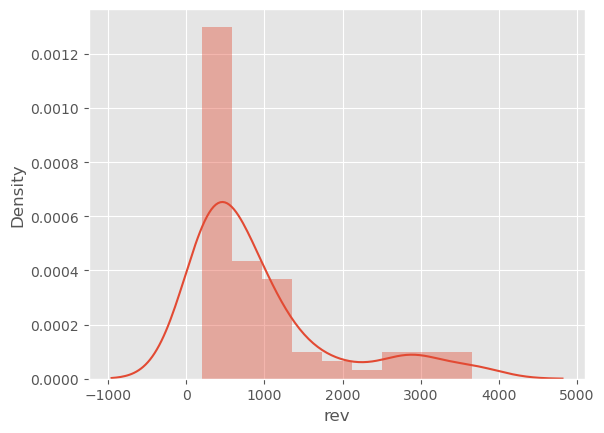

In [51]:
# выведем гистограмму распределения значений rev (без включения 0)
sns.distplot(A_group_full_info_test.query('rev > 0').rev)

C:\Users\Evgeniy\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rev', ylabel='Density'>

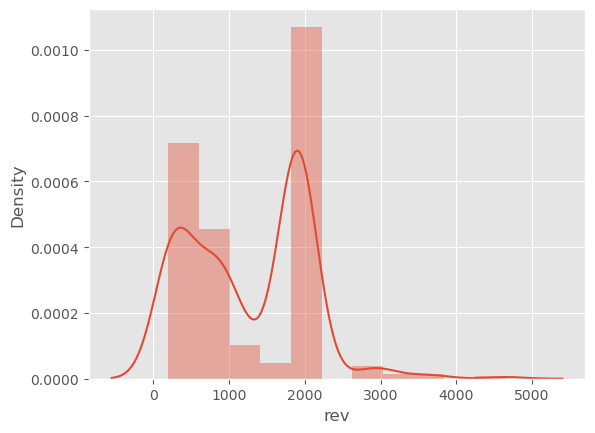

In [52]:
# выведем гистограмму распределения значений rev (без включения 0)
sns.distplot(B_group_full_info_test.query('rev > 0').rev)

Судя по графикам, распределение не является нормальным. 

Проверим дополнительно гипотезу о нормальности распределения тестом Шапиро-Уилка и тестом Колмогорова-Смирнова:

In [53]:
# Тест Шапиро-Уилка
stats.shapiro(A_group_full_info_test.query('rev>0').rev), stats.shapiro(B_group_full_info_test.query('rev>0').rev)

(ShapiroResult(statistic=0.7353235483169556, pvalue=1.4986777097103499e-10),
 ShapiroResult(statistic=0.8547242879867554, pvalue=1.5438489688266848e-16))

In [54]:
# Тест Колмогорова-Смирнова
stats.kstest(A_group_full_info_test.query('rev>0').rev, "norm", alternative='less') \
,stats.kstest(B_group_full_info_test.query('rev>0').rev, "norm", alternative='less')

(KstestResult(statistic=1.0, pvalue=0.0),
 KstestResult(statistic=1.0, pvalue=0.0))

Проверка нормальности:

- p-value теста Ш-У < 0.05 => выборки взяты из ГС, которая имеет распределение, отличающееся от нормального
- p-value теста К-С < 0.05 => отклонение от нормального распределения существенное

2.1 Средняя сумма покупки

**Выбор метода для сравнения значений из двух групп**

- t-тест. Необходимо 1) иметь внутри групп примерно одинаковые дисперсии т.к. размеры групп сильно отличаются; 2) Необходимо проверить нормальность распределения выборочных средних
- U-критерий Манна-Уитни. Желательно не иметь повторяющихся значений
- Bootstrap

In [55]:
# Проверка схожести дисперсий
stat, p = stats.levene(A_group_full_info_test.query('rev > 0').rev, B_group_full_info_test.query('rev > 0').rev)
stat, p

(3.075681699981606, 0.08025675761347022)

In [56]:
stats.mannwhitneyu(A_group_full_info_test.query('rev > 0').rev, B_group_full_info_test.query('rev > 0').rev)

MannwhitneyuResult(statistic=9001.0, pvalue=0.0002511393831406922)

- Критерий Манна-Уитни. **Не походит** из-за обнаруженных ранее повторяющихся сумм (290 и 1900)

- T-тест. p-value теста Левена > 0.05 => Принимаем гипотезу о равенстве дисперсий. В то же время, необходимо проверить, что при повторном множественном взятии средних значений, их распределение будет нормальным. У нас нет возможности делать повторные выборки для определения распределения средних, поэтому оценим это имеющейся выборке, превратив ее во много выборок и посчитав среднее для всех.

**Т.о., применим метод Bootstrap**

ГИПОТЕЗА 1

Н0 - среднее значение средней суммы оплаты среди платящих клиентов в обеих группах равно

Н1 - среднее значение средней суммы оплаты среди платящих клиентов в обеих группах равно

In [57]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

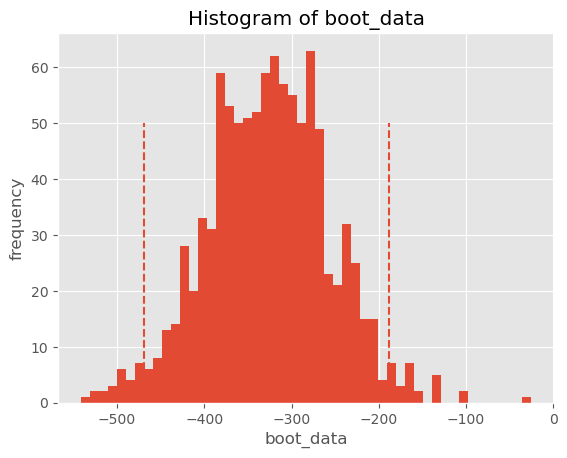

In [58]:
booted_data = get_bootstrap(
    A_group_full_info_test.query('rev > 0').rev,
    B_group_full_info_test.query('rev > 0').rev
             )

In [59]:
booted_data['p_value']

3.1818663952165784e-06

In [60]:
booted_data['ci']

,0
0.025,-469.123818
0.975,-188.332017


**p-value < 0.05** => **отклоняется нулевая гипотеза** и признается, что средние значения суммы покупки среди плативших пользователей в группах отличаются. 

**Однако** как было обнаружено ранее, нельзя полагаться на полученные результаты в подобном кейсе в реальной обстановке, т.к. существует неопределенность относительно того, что именно повлияло на изменение среднего чека среди платящих клиентов: новая методика оплаты или некая иная мг акция.

2.2 Конверсия из посетителей платформы в покупку

Сравним значения конверсии для двух групп. 

Будем использовать метод Хи-квадрат для категориального показателя: пользователь может быть конвертирован, а может нет (1/0)

**ГИПОТЕЗА 2**

Н0 - На коверсию не влияет изменение метода оплаты

Н1 - На коверсию влияет изменение метода оплаты

In [61]:
chi_test_df = full_info_test.fillna(0).query('grp != 0')

In [62]:
# создадим новый столбец на основе условия: была конверсия или нет
chi_test_df['is_converted'] = np.where(chi_test_df.rev > 0, 'convetred', 'not_converted')

In [63]:
chi_test_df

,student_id,grp,rev,is_converted
0,1627,A,990.0,convetred
1,2085,B,0.0,not_converted
2,2215,B,0.0,not_converted
3,3391,A,0.0,not_converted
4,3401,B,0.0,not_converted
...,...,...,...,...
8336,5760471,B,0.0,not_converted
8337,5777081,B,0.0,not_converted
8338,5870856,A,0.0,not_converted
8339,5945085,B,0.0,not_converted


In [64]:
# сгруппируем значения по наименованию группы и результату (конверсия да/нет)
chi_test_table = chi_test_df.groupby(['grp', 'is_converted'], as_index=False) \
    .agg({'student_id': 'count'})  \
    .rename(columns=({'student_id': 'stud_count'}))

In [65]:
chi_test_table

,grp,is_converted,stud_count
0,A,convetred,78
1,A,not_converted,1460
2,B,convetred,314
3,B,not_converted,6489


In [66]:
# Два отдельных df с фильтром по группам
a = chi_test_table[chi_test_table['grp'] == 'A']
b = chi_test_table[chi_test_table['grp'] == 'B']

In [67]:
# посчитаем количество пользователей в каждоый из групп
a_converted = a.query('is_converted == "convetred"').stud_count.sum()
a_not_converted = a.query('is_converted == "not_converted"').stud_count.sum()
b_converted = b.query('is_converted == "convetred"').stud_count.sum()
b_not_converted = b.query('is_converted == "not_converted"').stud_count.sum()

In [68]:
T = np.array([[a_converted, a_not_converted], [b_converted, b_not_converted]])

In [69]:
T

array([[  78, 1460],
       [ 314, 6489]], dtype=int64)

In [70]:
# p-value для Chi-square
scipy.stats.chi2_contingency(T,correction=False)[1]

0.44547028437158964

In [71]:
# Сверка значений с ранее посчитанным CR_A
(a_converted / (a_converted + a_not_converted)) * 100 == CR_A

True

In [72]:
# Сверка значений с ранее посчитанным CR_B
(b_converted / (b_converted + b_not_converted) * 100) == CR_B

True

**p-value > 0.05** => принимается нулевая гипотеза. Изменение метода оплаты не повлияло конвертирумеость клиентов.

### 3. Вывод

В результате анализа результатов A/B тестирования выявлено, что:
- Средние значения чека среди платящих клиентов (ARPPU) в двух группах отличается
- Новый метод оплаты не повлиял на конверсию в двух группах

На основе результатов, рекомендуется **не реализовывать** новый метод оплаты. 

Средний чек в группе с новым типом оплаты выше, однако рассуждая логически, есть сомнения, что метод оплаты может как-то влиять на средний чек. С оплатой клиент сталкивается в момент оформления товаров из корзины; на экране оплаты обычно не выбирают дополнительных товаров. Возможно, рост среднего чека как-то связан с маркетинговыми кампаниями, т.к. подозрительно много людей **только** в группе В имеют одинаковый чек в 1900.

Коэффициент конверсии в данном кейсе видится более значимой метрикой. Неудобный процесс оплаты может заставить клиента прекратить оформление заказа. Как расчитано выше, новый метод не повлиял на конверсию в оплату, и он не отличается в двух группах.

## ***Задание 2. SQL***
#### 2.1 Очень усердные ученики.

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".
Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

**Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.**

NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [73]:
connection_default = {'host':'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student',
                      'password':'dpo_python_2020'
                     }

In [74]:
q_successsful_students = '''
SELECT COUNT(DISTINCT st_id) as successful_students
FROM
    (
    SELECT st_id, SUM(correct) AS tasks_done
    FROM peas
    GROUP BY st_id
    HAVING tasks_done >= 20
    ORDER BY tasks_done DESC
    )
'''
#выбираем КОЛИЧЕСТВО усердных студентов. Источником является подзапрос, где выбраны только студенты 
#которые успешно решили >= 20 горошин (задач). Основной запрос считает уникальное кол-во ID студентов. 
#т.к. Correct - Boolean и принимает значения 1 или 0, берется сумма столбца correct, чтобы получить только решенные peas

In [75]:
df_peas_done = ph.read_clickhouse(query=q_successsful_students, connection=connection_default)

In [76]:
df_peas_done

,successful_students
0,136


#### 2.2 Оптимизация воронки

2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

Таблицы:

1) peas - данные о студентах и решенных задачах

2) studs - данные об эксперименте

3) final_project_check - данные о покупках полной версии

**Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:**

1) ARPU 

2) ARPAU 

3) CR в покупку 

4) СR активного пользователя в покупку 

5) CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

6) ARPU считается относительно всех пользователей, попавших в группы.

NB:
Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.
Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [196]:
q_metrics = '''
SELECT 
    test_grp,
    round(SUM(checks.money) / uniqExact(studs.st_id),2) AS ARPU,
    round(sumIf(checks.money, activeness.successful_tasks > 10 ) / uniqIf(activeness.st_id, activeness.successful_tasks > 10),2) AS ARPAU,
    round(uniqIf(studs.st_id, checks.money > 0) / uniqExact(studs.st_id) * 100,2) AS general_CR,
    round(uniqIf(studs.st_id, checks.money > 0 AND activeness.successful_tasks > 10) / uniqIf(studs.st_id, activeness.successful_tasks > 10) * 100,2) AS active_studs_CR,
    round(uniqIf(studs.st_id, activeness.math_successful_tasks >=2 AND checks.money > 0) / uniqIf(studs.st_id, activeness.math_successful_tasks >=2) * 100,2) AS math_active_CR
    FROM studs
LEFT JOIN 
    (
    SELECT
        st_id,
        SUM(correct) AS successful_tasks,
        sumIf(correct, subject = 'Math') AS math_successful_tasks
    FROM peas
    GROUP BY st_id) as activeness
ON studs.st_id = activeness.st_id
LEFT JOIN final_project_check as checks
ON studs.st_id = checks.st_id
GROUP BY test_grp
'''

#### Логика запроса: 
В запросе используются функции ClickHouse: -IF, round, uniq.

- Основной таблицей является studs (600 чел.)
- К ней присоединятся таблица peas с данными о количестве верно решенных заданиях (для выделения активных студентов) и данными о верно решенных заданиях по математике
- В конце присоединяется таблица с данными о суммах покупок
- Объединение всех таблиц возможно благодаря единому ID (st_id)
- Запрос группируется по типу тестовой группы для разделения метрик

In [197]:
df_students_metrics = ph.read_clickhouse(query=q_metrics, connection=connection_default)

In [198]:
df_students_metrics

,test_grp,ARPU,ARPAU,general_CR,active_studs_CR,math_active_CR
0,control,4540.98,10393.70,4.92,11.02,10.20
1,pilot,11508.47,29739.58,10.85,26.04,14.29


## ***Задание 3. Создание функции для автоматизации***

1. Необходимо реальзовать функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Необходимо создать функцию для построения графиков по получаемым метрикам

In [199]:
def update_metrics(uptdate_df):
    """Функция для автоматической загрузки дополнительных данных файла group_add и расчета ключевых метрик"""
    
    # загрузка датафреймов
    groups = pd.read_csv(
    '/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-avdonin/datasets/final_project_datasets/groups.csv',
    sep = ';')
    active_studs = pd.read_csv(
    '/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-avdonin/datasets/final_project_datasets/active_studs.csv',
    sep = ';')
    checks = pd.read_csv(
    '/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-avdonin/datasets/final_project_datasets/checks.csv',
    sep = ';')
    groups_add = pd.read_csv(
    uptdate_df)
    
    # переимнование header в единый вид; порядок колонок groups и groups_add может отличаться, поэтому учитвается 2 порядка
    if groups.dtypes[0] == int:
        groups.rename(columns={groups.columns[0]: 'student_id'}, inplace = True) # сначала id потом группа
        groups.rename(columns={groups.columns[1]: 'grp'}, inplace = True)
    else:
        groups.rename(columns={groups.columns[1]: 'grp'}, inplace = True) # сначала группа, потом id
        groups.rename(columns={groups.columns[0]: 'student_id'}, inplace = True)
      
    # тоже самое для groups_add
    if groups_add.dtypes[0] == int:
        groups_add.rename(columns={groups_add.columns[0]: 'student_id'}, inplace = True) # сначала id потом группа
        groups_add.rename(columns={groups_add.columns[1]: 'grp'}, inplace = True)
    else:
        groups_add.rename(columns={groups_add.columns[1]: 'grp'}, inplace = True) # сначала группа, потом id
        groups_add.rename(columns={groups_add.columns[0]: 'student_id'}, inplace = True)
       
    # объединение df
    both_groups = pd.concat([groups, groups_add])
    full_info_test = both_groups.merge(active_studs, on='student_id', how='inner') \
        .merge(checks, on='student_id', how='outer') 
    A_group_full_info_test = full_info_test.query('grp == "A"').fillna(0)
    B_group_full_info_test = full_info_test.query('grp == "B"').fillna(0)
    
    # рассчет метрик
    CR_A = round(A_group_full_info_test.query('rev > 0').student_id.count() / A_group_full_info_test.student_id.count()*100,2)
    CR_B = round(B_group_full_info_test.query('rev > 0').student_id.count() / B_group_full_info_test.student_id.count()*100,2)

    avg_rev_per_active_A = round(A_group_full_info_test.query('rev > 0').rev.mean(),2)
    avg_rev_per_active_B = round(B_group_full_info_test.query('rev > 0').rev.mean(),2)
                          
    return pd.DataFrame({'group_name': ['A', 'B'], \
                         'conversion_rate': [CR_A, CR_B], \
                         'ARPPU': [avg_rev_per_active_A, avg_rev_per_active_B]})

In [200]:
update_metrics('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-avdonin/datasets/final_project_datasets/group_add.csv')

,group_name,conversion_rate,ARPPU
0,A,5.07,933.59
1,B,4.62,1257.88


In [201]:
df = update_metrics('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-avdonin/datasets/final_project_datasets/group_add.csv')

In [202]:
def metrics_chart(source_df):
    """Функция для построения графиков по ключевым метрикам на основе результатов работы функции update_metrics()"""
    plt.figure(figsize=(10, 10))
    
    # график коверсии
    plt.figure(figsize=(10, 10))
    plt.title('Показатель конверсии по итогам A/B теста', fontsize=20)
    sns.barplot(data=df, x='group_name', y='conversion_rate', palette=['g','y']) \
        .set(xlabel='Тестовая группа', ylabel='Коэффициент конверсии, %')
    
    # график ARPPU
    plt.figure(figsize=(10, 10))
    plt.title('Средний доход на платящего пользователя по итогам A/B теста', fontsize=20)
    sns.barplot(data=df, x='group_name', y='ARPPU', palette=['y','g']) \
        .set(xlabel='Тестовая группа', ylabel='ARPPU, RUB')
    return plt.show()
    

<Figure size 720x720 with 0 Axes>

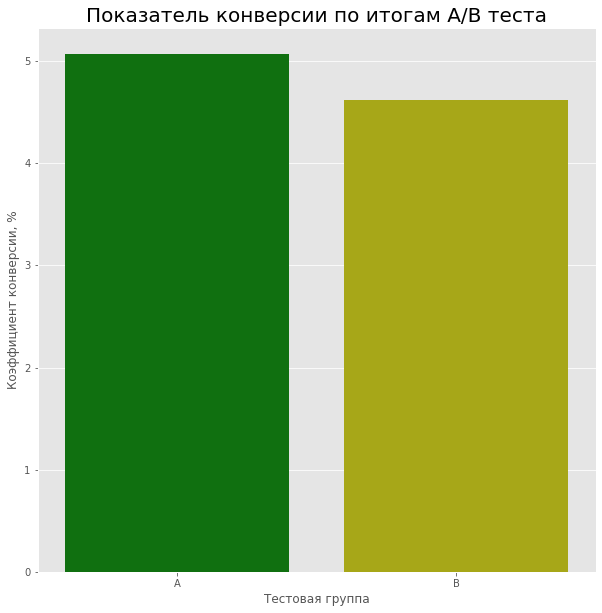

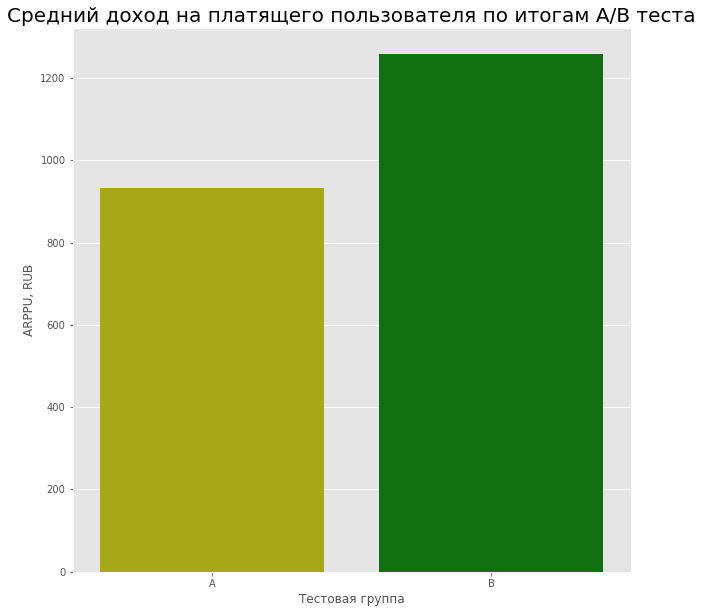

In [203]:
metrics_chart(df)